Author: Noah Ponto
This file contains experimentation code for saving a PNG file to an h5 file and
displaying the PNG again

Refrence: https://blade6570.github.io/soumyatripathy/hdf5_blog.html

1. Encode a single PNG into a hdf5 file

In [2]:
'''
Save a single PNG into an h5 file
'''
import h5py
import numpy as np
import os
from PIL import Image


img_path = '../output/images/png/CLEVR_new_000000camera_ori.png'
save_path = '../output/h5files/stored_png.hdf5'

# Open h5 file
os.remove(save_path)
hf_write = h5py.File(save_path, 'a') # open a hdf5 file


# Open PNG using PIL library
print('image size: %d bytes'%os.path.getsize(img_path))
img_np = np.array(Image.open(img_path))
img_np = img_np[:, :, :-1]  # Remove the A channel from the image
print(f'numpy shape {img_np.shape}')
dset = hf_write.create_dataset('default key', data=img_np)

# binary_data_np = np.asarray(binary_data)
# Write the data to hdf5 file
hf_write.close() # close the hdf5 file
print('hdf5 file size: %d bytes'%os.path.getsize(save_path))
print(f'saved to: {save_path}')

image size: 345316 bytes
numpy shape (240, 320, 3)
hdf5 file size: 232448 bytes
saved to: ../output/h5files/stored_png.hdf5


Keys: default key


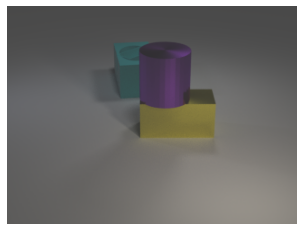

In [3]:
'''
Open the h5 file and display the image
'''
from matplotlib import pyplot as plt
from PIL import Image


hf_read = h5py.File(save_path, 'r')

key = list(hf_read.keys())[0]
print("Keys: %s" % key)

data = np.array(hf_read[key])
hf_read.close()

plt.axis('off')
plt.imshow(data)


2. Encode multiple PNG files into a single hdf5 file

In [4]:
'''
Save multiple png files into a single hdf5 file
'''
img_dir = '../output/images/png/'
num_imgs = 3
save_path = '../output/h5files/multiple_pngs.hdf5'

# Open the hdf5 file
if os.path.isfile(save_path): os.remove(save_path)
hf_write = h5py.File(save_path, 'a') # open a hdf5 file

for i, fname in enumerate(os.listdir(img_dir)):
    if (i >= num_imgs): break

    # Open the image
    img_path = os.path.join(img_dir, fname)
    img_np = np.array(Image.open(img_path))
    img_np = img_np[:, :, :-1] # Remove A channel, just RGB from img

    # Save the numpy array into the hdf5 file using the image filename as the key
    dset = hf_write.create_dataset(fname, data=img_np)
    print(f"stored {fname}")

hf_write.close()
    

stored CLEVR_new_000000camera1.png
stored CLEVR_new_000000camera2.png
stored CLEVR_new_000000camera_ori.png


3 keys
got key CLEVR_new_000000camera1.png
got key CLEVR_new_000000camera2.png
got key CLEVR_new_000000camera_ori.png


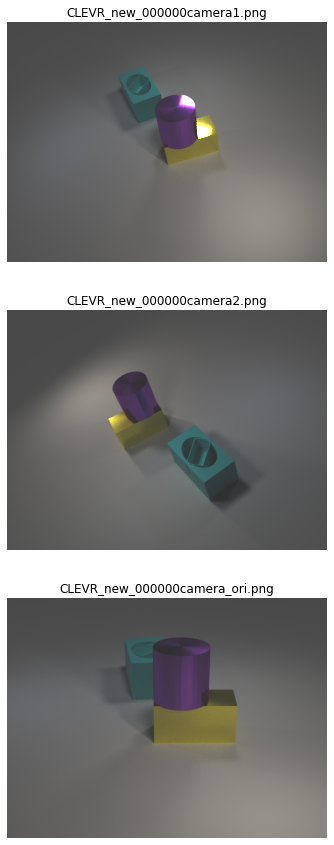

In [5]:
'''
Display the multiple images
'''
hf_read = h5py.File(save_path, 'r')

# Print all the keys
keys = list(hf_read.keys())
print(f"{len(keys)} keys")

imgs = {} # file_name -> img_nparray

# Get each image from the file
for key in keys:
    data = np.array(hf_read[key])
    imgs[key] = data
    print(f'got key {key}')

# Display all the images
fig, ax = plt.subplots(len(imgs))
fig.set_size_inches(15, 15)
for i, fname in enumerate(imgs):
    ax[i].imshow(imgs[fname])
    ax[i].set_title(fname)
    ax[i].axis('off')


hf_read.close()

3. Encode multiple scenes with predicates into a single hdf5 file

In [1]:
'''
Open multiple scenes (with multiple PNG views per scene), generate predicate information,
and save all data into a hdf5 file

scenes -> scene -> image/view -> actual RGB image data
                -> relations  -> relation -> boolean 10 x 10
                -> objects    -> object index -> object info
'''
import h5py
import numpy as np
import os
import json

num_scenes = 1  # Number of scenes to include in output h5 file
img_dir = '../output/images/png/'
scn_dir = '../output/scenes/'
save_path = '../output/h5files/stored_scenes.hdf5'

# Open the hdf5 file
if os.path.isfile(save_path): os.remove(save_path)
hf_write = h5py.File(save_path, 'a') # open a hdf5 file
# TODO: use just number as key
# TODO: only generate original views, not multiple views 'image' as key
# TODO: only do front, right, contains, supports relations
# TODO: store objects as single string of comma separated list 'objects' as key

scene_template = 'CLEVR_new_%06d'
img_dir_idx = 0
png_paths = os.listdir(img_dir)
total_images_size = 0

for i in range(num_scenes):
    # Create group for scene
    scene_name = scene_template % i
    scene_grp = hf_write.create_group(scene_name)
    
    ### ADD CAMERA VIEWS ###
    images_grp = scene_grp.create_group('images')
    cameras = [x for x in png_paths if x.startswith(scene_name)]
    for cam in cameras:
        cam_pth = os.path.join(img_dir, cam)
        total_images_size += os.path.getsize(cam_pth)
        # Extract data from image
        with open(cam_pth, 'rb') as img_f:
            binary_data = img_f.read()
        binary_data_np = np.asarray(binary_data)
        # Store data in h5 file
        dset = images_grp.create_dataset(cam, data=binary_data_np)
    
    ### ADD PREDICATES ###
    relations_grp = scene_grp.create_group('relations')
    # 1. Open json file
    json_path = scn_dir + scene_name + '.json'
    with open(json_path) as json_f:
        json_data = json.load(json_f)
    num_objs = len(json_data['objects']) # number objs in scene
    rel_arr_shape = (num_objs, num_objs) # create square array for each relation
    # 2. Add front, behind, left, right relations
    relationships = list(json_data['relationships'].keys())
    for rel in relationships:
        # rel_grp = relations_grp.create_group(rel)
        bool_arr = np.zeros(rel_arr_shape, dtype=bool)
        for first_obj_idx, other_objs_idxs in enumerate(json_data['relationships'][rel]):
            # for other_obj_idx in other_objs_idxs: 
            bool_arr[other_objs_idxs, first_obj_idx] = True
        dset = relations_grp.create_dataset(rel, data=bool_arr)
    # 3. Add support, contains relations
    sup_arr = np.zeros(rel_arr_shape, dtype=bool)
    con_arr = np.zeros(rel_arr_shape, dtype=bool)
    # iterate through objects and record their relations
    for obj_idx, obj_dict in enumerate(json_data['objects']):
        child_idx = obj_dict['child']
        if obj_dict['used'] == 'sup':
            sup_arr[obj_idx, child_idx] = True
        elif obj_dict['used'] == 'con':
            con_arr[obj_idx, child_idx] = True
        # else: continue
        # Find the child object
        # for cld_idx, search_obj in enumerate(json_data['objects']):
        #     if search_obj == child_obj:
        #         arr[obj_idx, cld_idx] = True
        #         break
    # Add support and contains to h5 file
    relations_grp.create_dataset('support', data=sup_arr)
    relations_grp.create_dataset('contain', data=con_arr)
    
    ### ADD OBJECTS ###
    format = '%s %s %s'
    objects = np.array([format % (x['color'], x['material'], x['shape']) for x in json_data['objects']], dtype="S")
    scene_grp.create_dataset('objects', data=objects)
# Print summary
scenes = list(hf_write.keys())
print(f"Saved scenes {scenes[0]} to {scenes[-1]}")
hf_write.close()
print('sum of individual image sizes:\t%dkB' % (total_images_size/1000))
h5_size = os.path.getsize(save_path)
print('hdf5 file size:\t\t\t%dkB' % (h5_size/1000))
diff = float(h5_size-total_images_size)
print(f'difference (overhead):\t{diff/1000}kB')
print(f'percent increase:\t{round(diff/h5_size*100, 3)}%')

None
None
None
Saved scenes CLEVR_new_000000 to CLEVR_new_000000
sum of individual image sizes:	293kB
hdf5 file size:			302kB
difference (overhead):	8.648kB
percent increase:	2.859%


Scenes: ['CLEVR_new_000000']


TypeError: 'AxesSubplot' object is not subscriptable

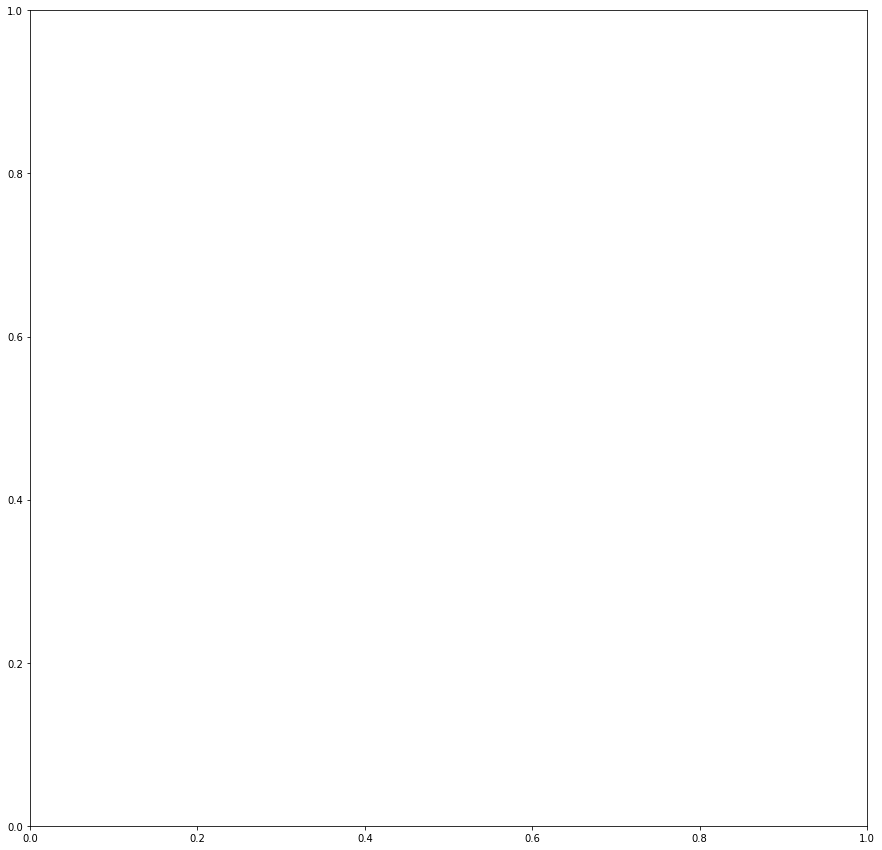

In [3]:
'''
Display images and predicates for a scene
'''
from PIL import Image
from matplotlib import pyplot as plt
import io

hf_read = h5py.File(save_path, 'r')

# Print all scenes
scenes = list(hf_read.keys())
print(f'Scenes: {scenes}')

# Print all views for a scene
scene = scenes[0]
img_names = list(hf_read[scene]['images'].keys())
fig, ax = plt.subplots(len(img_names))
fig.set_size_inches(15, 15)
for i, iname in enumerate(img_names):
    # Get the raw image bytes
    idata = np.array(hf_read[scene]['images'][iname])
    # Convert the bytes into an RGBA numpy array
    img = np.array(Image.open(io.BytesIO(idata)))
    # Display the numpy array
    ax[i].imshow(img)
    ax[i].set_title(iname)
    ax[i].axis('off')

# Print all predicates
objects = [x.decode() for x in list(hf_read[scene]['objects'])]
relations = list(hf_read[scene]['relations'].keys())
print(f"Relations: {relations}")
for relation in ['front', 'right', 'contain', 'support']:
    print(relation.upper())
    mat: np.ndarray = np.array(hf_read[scene]['relations'][relation])
    assert(mat.size == len(objects)**2)
    for i in range(len(objects)):
        for j in range(len(objects)):
            if i != j and mat[i, j]:
                print(f"{objects[i]} {relation} {objects[j]}")


# Display all views for a scene
hf_read.close()